# LSI and LDA Analysis Notebook

UPDATE: While much work has been done to clean up the text there is clearly much more to be done at this point. For instance, the NLTK PorterStemmer seems to not have done as good of a job at stemming the words as we would have liked, and there are still stop words and other characters that carry trivial meaning that are showing up as main factors in some of our topics in both the LSI and LDA models.

In [1]:
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import lsimodel
from gensim.models import ldamodel
from gensim import corpora

%matplotlib inline

In [184]:
pd.set_option('display.max_info_columns',200)
pd.set_option('display.max_colwidth',200)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

In [4]:
df = pd.read_csv('../Data/cleaned.csv', sep=',', quotechar='"', index_col=0, header=0)
df.head()

user.description  \
0    Part of the #VastRightWingConspiracy -- thanks, @HillaryClinton. Better candidate: https://www.randpaul.com/ Retweeting not endorsement. Image: TV lover.   
1                                     War Veteran who loves his country. Never forget those who died in 'Benghazi'.  864th Engineer Battalion (Combat) (Heavy)   
2                      Retired: cowboy,truck driver Served in the USAF, hobbies include Shooting sports and hunt and camp born in Calif.and sadly left in 1984   
3  Bartender...Bouncer...Autobody......Gravedigger.....Supermodal......OG.....Playboy.........:)\r\n\r\n\r\nDAM...NICE...GUY...MAFIA   DEMOLITION  INSTALATION   
4                                                                                                                      Ming doesn't have a trajectory problem.   

                                                                                                                                                text  \
0            #BanTheBox means "all is #forgiven"/NO MORE federal #NCIC checks when buying guns? Please consider it, Mr. President @POTUS. #forgiving   
1  BOYCOTT NOV 4 @ABC @CMAwards &gt; THREAT TO ALL GUN OWNERS - BOYCOTT HIS MUSIC &gt; @TheTimMcGraw GUN CONTROL EXTREMIST https://t.co/xMuE2o7vV7 …   
2                  Savage: This is the Most Corrupt, Degenerate, Criminal Gov’t in American History https://t.co/qW12kzuBWH Take my guns lead first.   
3                                                                                 Guns N' Roses - November Rain https://t.co/w2pHuG0QBa via @YouTube   
4       I'll say it again: #Tarantino was merely correct. And, to his credit, he's sticking to his rhetorical guns. #BadCops https://t.co/7M4uTpXwyc   

  topic  log_followers  log_retweets  engagement_flag  \
0     G       5.252273           0.0                0   
1     G       9.936148           0.0                0   
2     G       4.043051           0.0                0   
3     G       6.107023           0.0                0   
4     G       5.081404           0.0                0   

                                                                                                                                                                                                text_token  \
0  [u'#BanTheBox', u'means', u'"', u'all', u'is', u'#forgiven', u'"', u'/', u'NO', u'MORE', u'federal', u'#NCIC', u'checks', u'when', u'buying', u'guns', u'?', u'Please', u'consider', u'it', u',', u'...   
1  [u'BOYCOTT', u'NOV', u'4', u'@ABC', u'@CMAwards', u'>', u'THREAT', u'TO', u'ALL', u'GUN', u'OWNERS', u'-', u'BOYCOTT', u'HIS', u'MUSIC', u'>', u'@TheTimMcGraw', u'GUN', u'CONTROL', u'EXTREMIST', u...   
2  [u'Savage', u':', u'This', u'is', u'the', u'Most', u'Corrupt', u',', u'Degenerate', u',', u'Criminal', u'Gov', u'', u't', u'in', u'American', u'History', u'https://t.co/qW12kzuBWH', u'Take', u'my'...   
3                                                                                             [u'Guns', u'N', u"'", u'Roses', u'-', u'November', u'Rain', u'https://t.co/w2pHuG0QBa', u'via', u'@YouTube']   
4  [u"I'll", u'say', u'it', u'again', u':', u'#Tarantino', u'was', u'merely', u'correct', u'.', u'And', u',', u'to', u'his', u'credit', u',', u"he's", u'sticking', u'to', u'his', u'rhetorical', u'gun...   

                                                                                                                                                                                              text_stemmed  \
0  [u'#banthebox', u'mean', u'"', u'all', u'is', u'#forgiven', u'"', u'/', u'NO', u'more', u'feder', u'#ncic', u'check', u'when', u'buy', u'gun', u'?', u'pleas', u'consid', u'it', u',', u'Mr', u'.', ...   
1  [u'boycott', u'nov', u'4', u'@abc', u'@cmaward', u'>', u'threat', u'TO', u'all', u'gun', u'owner', u'-', u'boycott', u'hi', u'music', u'>', u'@thetimmcgraw', u'gun', u'control', u'extremist', u'ht...   
2  [u'savag', u':', u'thi', u'is', u'the', u'most', u'corr

## What is the breakdown of the tweet distribution

In [5]:
docs = df.text_processed.dropna().tolist()
docs_token = df.text_stemmed.dropna().tolist()
print ("%s gun control tweets, %s gay marriage tweets, and %s climate change tweets" %("{:,}".format(df[df.topic == 'G'].count()[0]), "{:,}".format(df[df.topic == 'M'].count()[0]), "{:,}".format(df[df.topic == 'C'].count()[0])))
print ("%s tweets for LSI" %("{:,}".format(len(docs))))

144,485 gun control tweets, 177,177 gay marriage tweets, and 231,423 climate change tweets
553,086 tweets for LSI


### Clean up the text some more

In [6]:
docs[831]

'ridicul :-) https://t.co/btphogh62c'

In [7]:
keep = set(['!','?','@','#','&', "'"])
remove = set([x for x in list(string.punctuation) if x not in keep])
docs = [[d for d in doc.split(" ") if d not in remove] for doc in docs]

In [8]:
docs[831]

['ridicul', ':-)', 'https://t.co/btphogh62c']

## LSI via SciKit-Learn's Truncated SVD

The LSI seems to have done a fair job at finding words that fit into a category, but most categories seem to correspond to the overall subject matter as opposed to finding nuances within a topic.

In [29]:
tvec = TfidfVectorizer(min_df=.0001, max_df=.2, stop_words='english', ngram_range=(1,2))
tvec_weights = tvec.fit_transform(docs)
tvec_weights

In [41]:
lsa = TruncatedSVD(random_state=0,n_components=100, n_iter=100)
lsa.fit(tvec_weights)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=100,
       random_state=0, tol=0.0)

In [42]:
terms = tvec.get_feature_names()

In [43]:
for i, comp in enumerate(lsa.components_):
    comp_terms = zip(terms,comp)
    sort_terms = sorted(comp_terms, key=lambda x: x[1], reverse=True)[:20]
    print ("Concept %d" %(i))
    for t in sort_terms:
        print (t[0])
    print(" ")

Concept 0
global
warm
global warm
wed
climat chang
gun
009f
f0
f0 009f
marriag
thi
0098
climatechang
009f 0098
chang https
new
say
warm https
obama
like
 
Concept 1
009f
f0
f0 009f
wed
0098
009f 0098
0082
0098 0082
0092
009f 0092
0091
009f 0091
008d
008f
wed https
0082 f0
bride
009f 008f
0098 008d
marriag
 
Concept 2
mph
wind
weather report
weather
report
report wind
wind speed
gust
mph gust
mph temp
wonderland weather
hydeparkwind
hydeparkwind wonderland
wonderland
speed
wind chill
temp
chill
speed mph
rain
 
Concept 3
warm
global warm
global
009f
f0
f0 009f
0098
009f 0098
warm https
0082
0098 0082
mph
wind
0092
0091
009f 0092
009f 0091
008f
008d
0082 f0
 
Concept 4
wed
wed https
warm
global warm
global
photo
dress
bride
wed dress
day
wed photo
wed day
love
beauti
mayo360group
warm https
mayo360group new
ring
invit
bridal
 
Concept 5
climat chang
chang https
climatechang
wed
threat
world
sander
terror
berni
climatechang https
exxon
gate
pari
say
save climat
save
new
caus
cop21
social


## LSI via the Gensim Library

In [9]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(docs)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [10]:
lsi = lsimodel.LsiModel(corpus, id2word=dictionary, num_topics=50  )

In [ ]:
prob_mat_lsi = dict()
for line in topicWordProbMat:
    topic, words = line
    probs = words.split(" + ")
    for pr in probs:
        word_pr = pr.strip().split("*")
        try:
            prob_mat_lsi[word_pr[1][1:-1]][topic] = float(word_pr[0])
        except:
            prob_mat_lsi[word_pr[1][1:-1]] = [0.0]*K
            prob_mat_lsi[word_pr[1][1:-1]][topic] = float(word_pr[0])
for k in prob_mat_lsi.keys():
    s = np.sum(prob_mat_lsi[k])
    prob_mat_lsi[k].append(s)

In [13]:
lsi.get_topics().shape, len(lsi.show_topics())

((50, 632439), 50)

In [285]:
K_lsi = lsi.num_topics
topicWordProbMat_lsi = lsi.show_topics(K_lsi, num_words=20)
prob_mat_lsi = dict()

for line in topicWordProbMat_lsi:
    topic, words = line
    probs = words.split(" + ")
    for pr in probs:
        word_pr = pr.strip().split("*")
        try:
            prob_mat[word_pr[1][1:-1]][topic] = float(word_pr[0])
        except:
            prob_mat_lsi[word_pr[1][1:-1]] = [0.0]*K_lsi
            prob_mat_lsi[word_pr[1][1:-1]][topic] = float(word_pr[0])
for k in prob_mat_lsi.keys():
    s = np.sum(prob_mat_lsi[k])
    prob_mat_lsi[k].append(s)

df_viz_lsi = pd.DataFrame.from_dict(prob_mat_lsi, orient='index')
df_viz_lsi.rename(columns={50: 'sum'}, inplace=True)
df_viz_lsi = df_viz_lsi.sort_values(by=['sum'], ascending=False)
df_viz_lsi.head(20)

0    1    2    3    4    5    6    7    8    9  ...       41  \
#2a       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
<u+00ab>  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
<u+00ba>  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
<u+00b8>  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
#gunsens  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
mormon    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
marriag   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.136   
amend     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
#wed      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
2nd       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
<u+00ac>  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
<u+00ad>  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
<u+00bb>  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
kurt      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
gay       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
<u+00bc>  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
arm       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
#nra      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
wed       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   
bride     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000   

             42   43   44   45     46     47   48     49    sum  
#2a       0.000  0.0  0.0  0.0  0.000  0.234  0.0  0.000  0.234  
<u+00ab>  0.000  0.0  0.0  0.0  0.226  0.000  0.0  0.000  0.226  
<u+00ba>  0.000  0.0  0.0  0.0  0.000  0.000  0.0  0.220  0.220  
<u+00b8>  0.000  0.0  0.0  0.0  0.000  0.000  0.0  0.217  0.217  
#gunsens  0.000  0.0  0.0  0.0  0.000  0.175  0.0  0.000  0.175  
mormon    0.146  0.0  0.0  0.0  0.000  0.000  0.0  0.000  0.146  
marriag   0.000  0.0  0.0  0.0  0.000  0.000  0.0  0.000  0.136  
amend     0.000  0.0  0.0  0.0  0.000  0.000  0.0  0.112  0.112  
#wed      0.000  0.0  0.0  0.0  0.000  0.000  0.0  0.000  0.082  
2nd       0.000  0.0  0.0  0.0  0.000  0.000  0.0  0.073  0.073  
<u+00ac>  0.000  0.0  0.0  0.0  0.000  0.000  0.0  0.073  0.073  
<u+00ad>  0.000  0.0  0.0  0.0  0.000  0.000  0.0  0.000  0.040  
<u+00bb>  0.000  0.0  0.0  0.0  0.000  0.000  0.0  0.000 -0.039  
kurt      0.000  0.0  0.0  0.0 -0.063  0.000  0.0  0.000 -0.063  
gay       0.000  0.0  0.0  0.0  0.000  0.000  0.0  0.000 -0.072  
<u+00bc>  0.000  0.0  0.0  0.0 -0.079  0.000  0.0  0.000 -0.079  
arm       0.000  0.0  0.0  0.0  0.000 -0.093  0.0  0.000 -0.093  
#nra      0.000  0.0  0.0  0.0  0.000  0.000  0.0 -0.093 -0.093  
wed       0.000  0.0  0.0  0.0  0.000  0.000  0.0  0.000 -0.094  
bride     0.000  0.0  0.0  0.0  0.000  0.000  0.0 -0.095 -0.095  

[20 rows x 51 columns]

In [291]:
np.min(df_viz_lsi.iloc[:,:50].values), np.max(df_viz_lsi.iloc[:,:50].values)

(-0.40000000000000002, 0.23400000000000001)

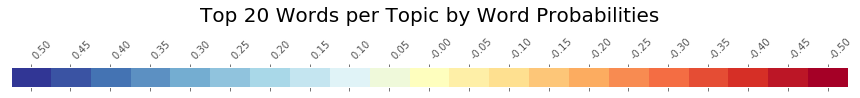

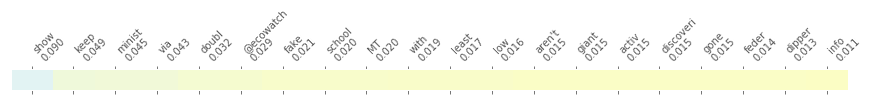

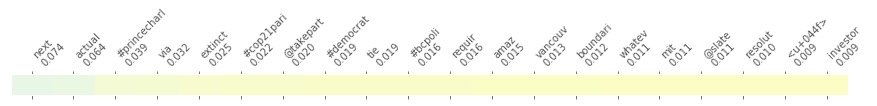

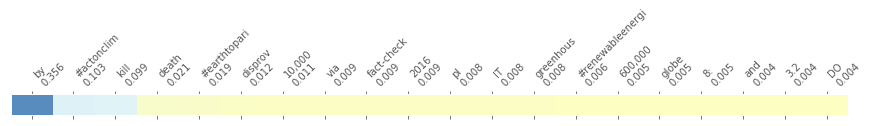

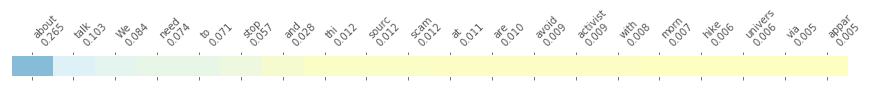

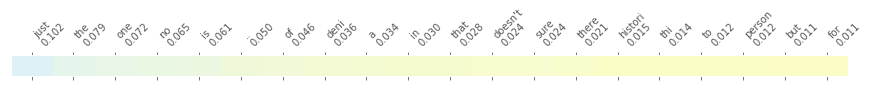

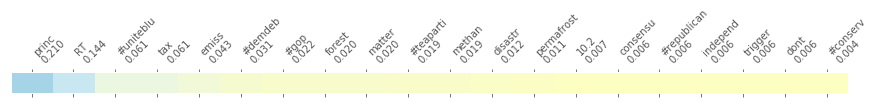

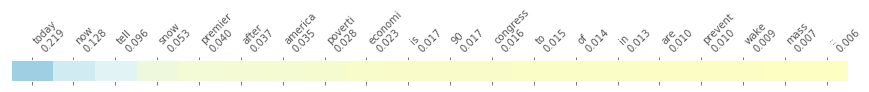

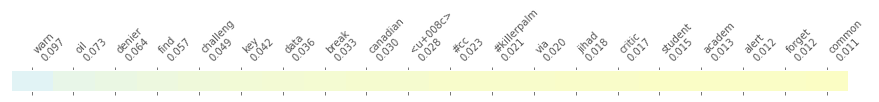

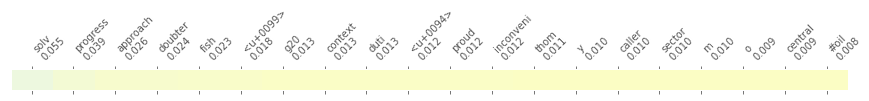

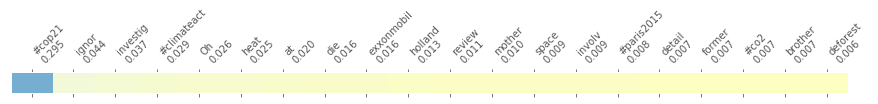

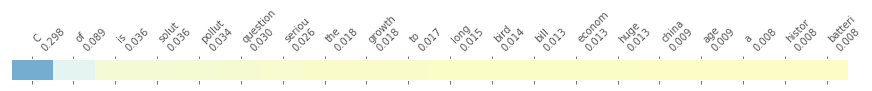

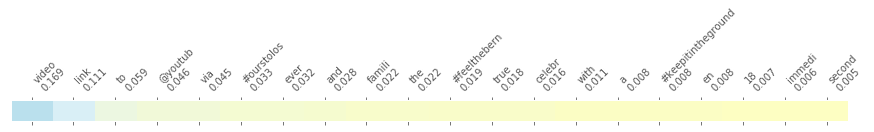

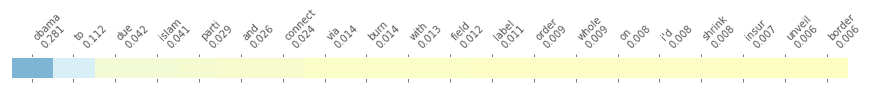

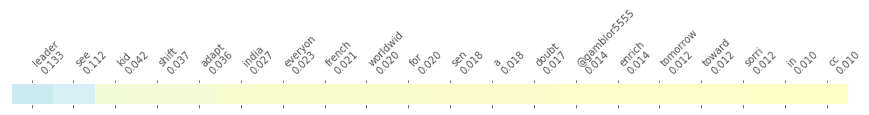

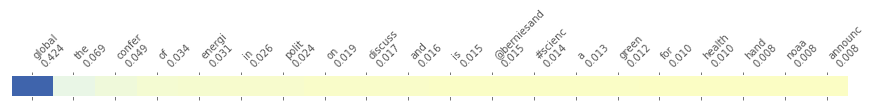

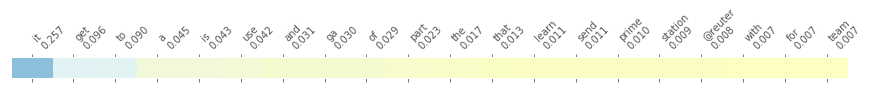

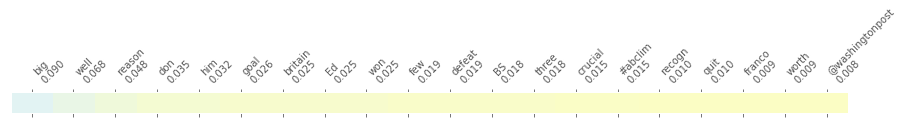

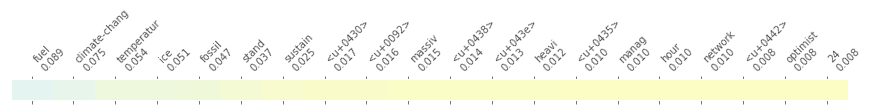

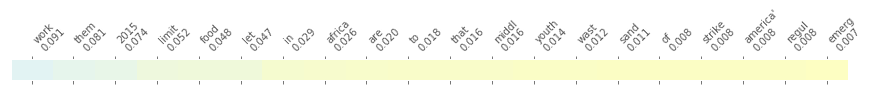

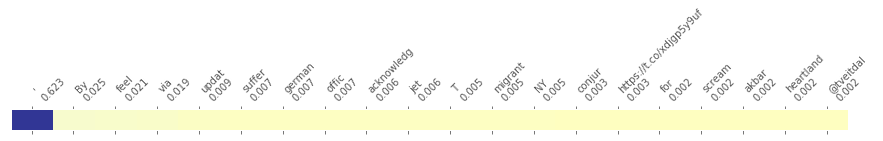

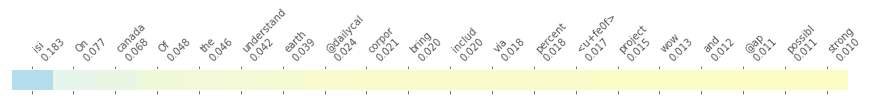

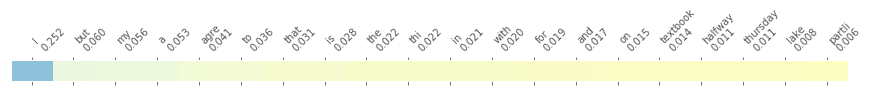

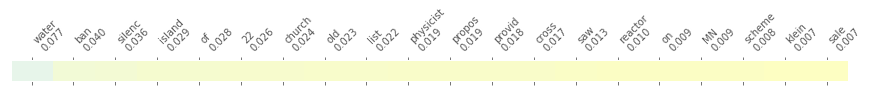

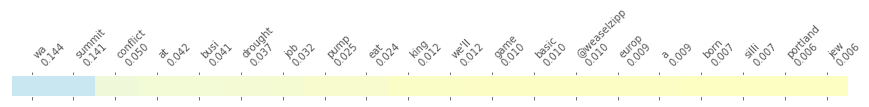

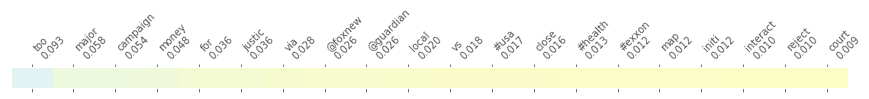

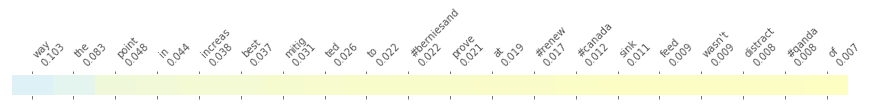

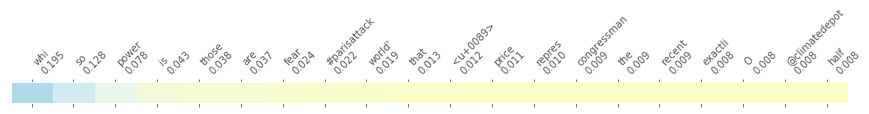

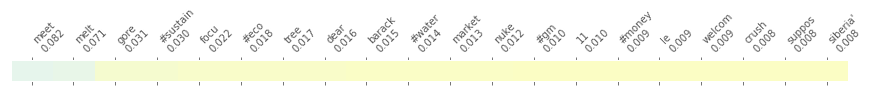

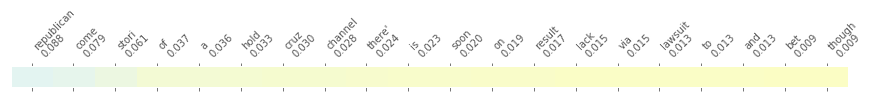

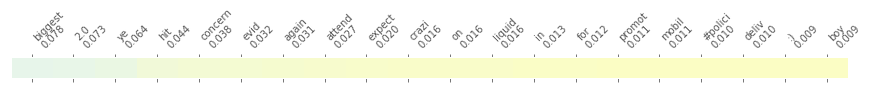

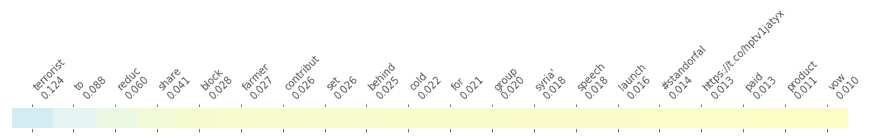

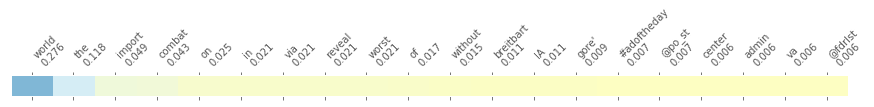

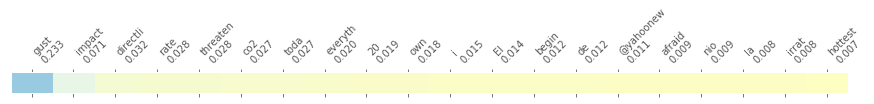

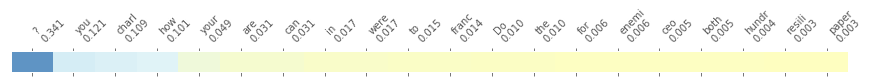

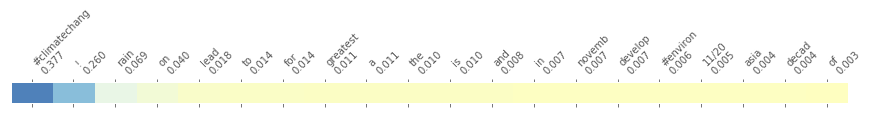

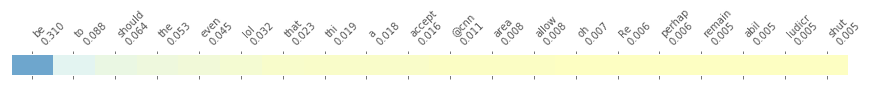

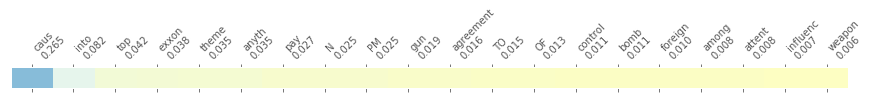

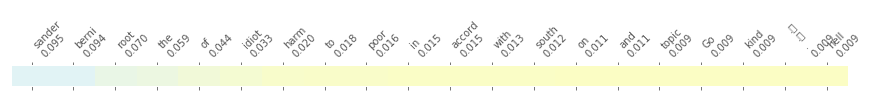

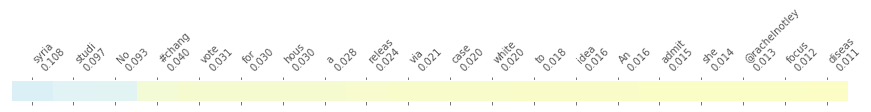

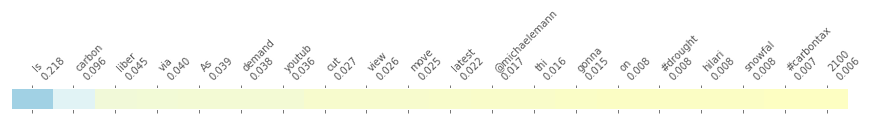

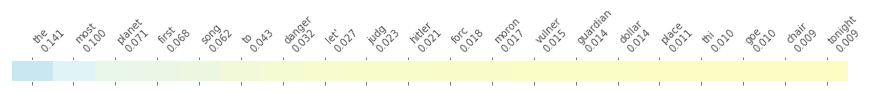

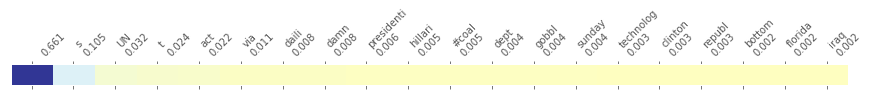

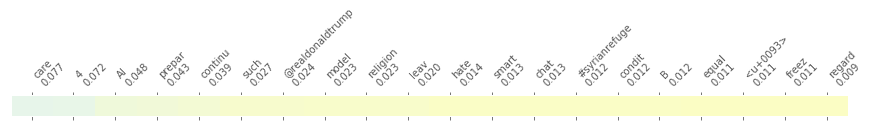

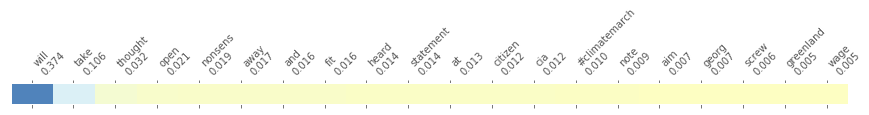

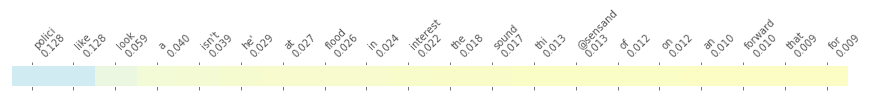

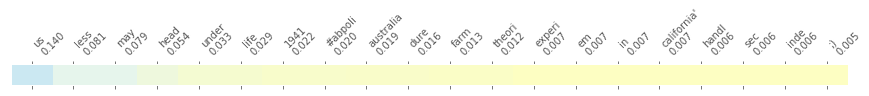

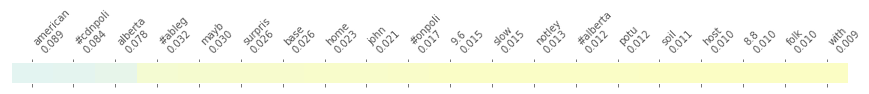

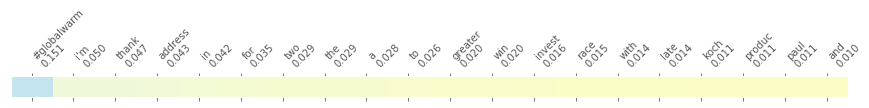

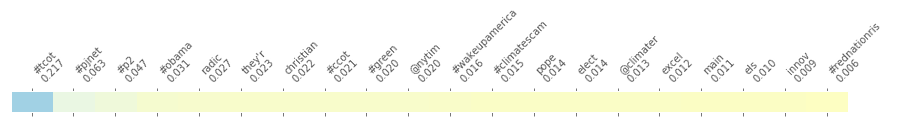

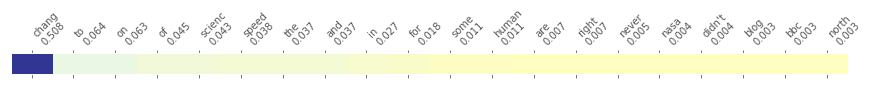

In [292]:
for i in range(K_lsi):
    if i == 0:
        fig = plt.figure(figsize=(15,6))
        ax = fig.add_subplot(111)
        ax.grid(False)
        
        mat = [x for x in reversed(np.arange(-0.5,0.55,0.05))]
        ax.matshow(np.array(zip([0]*len(mat),mat)).T, vmin=-0.5, vmax=0.5, cmap=plt.cm.RdYlBu)
        ax.set_xticklabels(['{0:.2f}'.format(x) for x in mat], rotation=45)
        for tick in ax.xaxis.get_majorticklabels():
            tick.set_horizontalalignment('left')
        ax.set_ylim(0.5,1)
        ax.set_yticks([])
        ax.set_yticklabels([])
        plt.xticks(np.arange(0, len(mat), 1.0))
        plt.title('Top 20 Words per Topic by Word Probabilities', y=3, fontsize=20)
        
    fig = plt.figure(figsize=(15,1))
    ax = fig.add_subplot(111)
    ax.grid(False)
    
    mat = pd.DataFrame(df_viz[i][df_viz[i] > 0]).sort_values(by=i, ascending=False)
    ax.matshow(np.array(zip([0]*len(mat.values),list(mat.values))).T, vmin=-0.5, vmax=0.5, cmap=plt.cm.RdYlBu)
    ax.set_xticks(np.arange(0, len(mat.values), 1.0))
    ax.set_xticklabels([mat.index.values[x] + "\n"'{0:.3f}'.format(float(mat.values[x])) for x in range(len(mat.values))], rotation=45)
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('left')
    ax.set_ylim(0.5,1)
    ax.set_yticks([])
    ax.set_yticklabels([])
    
plt.show()

## LDA Model via Gensim

In [14]:
ldamodel = ldamodel.LdaModel(corpus, num_topics=100, id2word=dictionary)
print (ldamodel)

LdaModel(num_terms=632439, num_topics=100, decay=0.5, chunksize=2000)


In [ ]:
print(ldamodel.print_topics(num_topics=100, num_words=10))

In [123]:
K = ldamodel.num_topics
topicWordProbMat = ldamodel.print_topics(K, num_words=20)
prob_mat = dict()

for line in topicWordProbMat:
    topic, words = line
    probs = words.split(" + ")
    for pr in probs:
        word_pr = pr.strip().split("*")
        try:
            prob_mat[word_pr[1][1:-1]][topic] = float(word_pr[0])
        except:
            prob_mat[word_pr[1][1:-1]] = [0.0]*K
            prob_mat[word_pr[1][1:-1]][topic] = float(word_pr[0])
for k in prob_mat.keys():
    s = np.sum(prob_mat[k])
    prob_mat[k].append(s)

In [185]:
df_viz = pd.DataFrame.from_dict(prob_mat, orient='index')
df_viz.rename(columns={100: 'sum'}, inplace=True)
df_viz = df_viz.sort_values(by=['sum'], ascending=False)
df_viz.head(20)

0      1      2      3      4    5      6     7    8    9  \
the            0.000  0.000  0.000  0.000  0.079  0.0  0.000  0.00  0.0  0.0   
to             0.000  0.000  0.000  0.071  0.012  0.0  0.015  0.00  0.0  0.0   
of             0.000  0.000  0.000  0.000  0.046  0.0  0.014  0.00  0.0  0.0   
climat         0.000  0.000  0.000  0.000  0.000  0.0  0.000  0.00  0.0  0.0   
is             0.000  0.000  0.000  0.000  0.061  0.0  0.017  0.00  0.0  0.0   
a              0.000  0.000  0.000  0.000  0.034  0.0  0.000  0.00  0.0  0.0   
               0.000  0.000  0.000  0.000  0.000  0.0  0.000  0.00  0.0  0.0   
...            0.000  0.000  0.000  0.000  0.000  0.0  0.000  0.00  0.0  0.0   
'              0.000  0.000  0.000  0.000  0.000  0.0  0.000  0.00  0.0  0.0   
in             0.000  0.000  0.000  0.000  0.030  0.0  0.013  0.00  0.0  0.0   
via            0.043  0.032  0.009  0.005  0.000  0.0  0.000  0.02  0.0  0.0   
and            0.000  0.000  0.004  0.028  0.000  0.0  0.000  0.00  0.0  0.0   
warm           0.000  0.000  0.000  0.000  0.000  0.0  0.000  0.00  0.0  0.0   
chang          0.000  0.000  0.000  0.000  0.000  0.0  0.000  0.00  0.0  0.0   
for            0.000  0.000  0.000  0.000  0.011  0.0  0.000  0.00  0.0  0.0   
?              0.000  0.000  0.000  0.000  0.000  0.0  0.000  0.00  0.0  0.0   
global         0.000  0.000  0.000  0.000  0.000  0.0  0.000  0.00  0.0  0.0   
&              0.000  0.000  0.000  0.000  0.000  0.0  0.000  0.00  0.0  0.0   
on             0.000  0.000  0.000  0.000  0.000  0.0  0.000  0.00  0.0  0.0   
#climatechang  0.000  0.000  0.000  0.000  0.000  0.0  0.000  0.00  0.0  0.0   

               ...       91     92     93     94   95   96     97   98   99  \
the            ...    0.000  0.000  0.000  0.101  0.0  0.0  0.000  0.0  0.0   
to             ...    0.000  0.000  0.000  0.018  0.0  0.0  0.012  0.0  0.0   
of             ...    0.000  0.000  0.000  0.047  0.0  0.0  0.000  0.0  0.0   
climat         ...    0.000  0.000  0.000  0.000  0.0  0.0  0.000  0.0  0.0   
is             ...    0.000  0.000  0.000  0.020  0.0  0.0  0.000  0.0  0.0   
a              ...    0.000  0.000  0.000  0.041  0.0  0.0  0.000  0.0  0.0   
               ...    0.000  0.000  0.000  0.000  0.0  0.0  0.000  0.0  0.0   
...            ...    0.000  0.000  0.000  0.000  0.0  0.0  0.000  0.0  0.0   
'              ...    0.000  0.000  0.000  0.000  0.0  0.0  0.000  0.0  0.0   
in             ...    0.000  0.000  0.000  0.037  0.0  0.0  0.013  0.0  0.0   
via            ...    0.000  0.000  0.007  0.000  0.0  0.0  0.000  0.0  0.0   
and            ...    0.000  0.019  0.000  0.015  0.0  0.0  0.000  0.0  0.0   
warm           ...    0.000  0.000  0.000  0.000  0.0  0.0  0.000  0.0  0.0   
chang          ...    0.000  0.000  0.000  0.000  0.0  0.0  0.000  0.0  0.0   
for            ...    0.000  0.000  0.004  0.018  0.0  0.0  0.000  0.0  0.0   
?              ...    0.000  0.000  0.000  0.000  0.0  0.0  0.000  0.0  0.0   
global         ...    0.000  0.000  0.000  0.000  0.0  0.0  0.000  0.0  0.0   
&              ...    0.000  0.000  0.000  0.000  0.0  0.0  0.000  0.0  0.0   
on             ...    0.013  0.000  0.000  0.000  0.0  0.0  0.000  0.0  0.0   
#climatechang  ...    0.000  0.000  0.000  0.000  0.0  0.0  0.000  0.0  0.0   

                 sum  
the            1.690  
to             1.445  
of             0.870  
climat         0.815  
is             0.738  
a              0.694  
               0.661  
...            0.649  
'              0.623  
in             0.587  
via            0.549  
and            0.536  
warm           0.508  
chang          0.508  
for            0.477  
?              0.428  
global         0.424  
&              0.422  
on             0.410  
#climatechang  0.377  

[20 rows x 101 columns]

In [293]:
np.min(df_viz.iloc[:,:100].values), np.max(df_viz.iloc[:,:100].values)

(0.0, 0.81499999999999995)

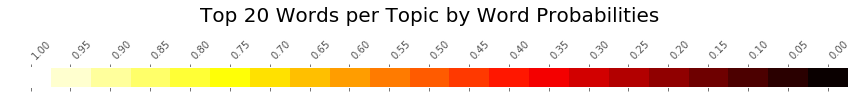

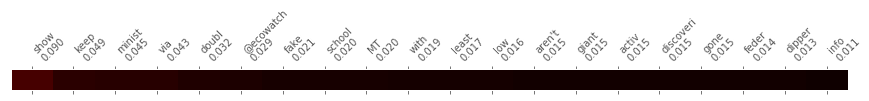

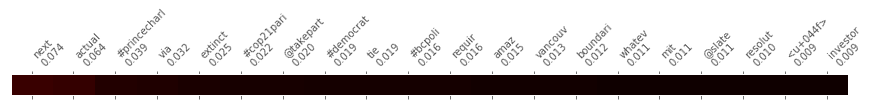

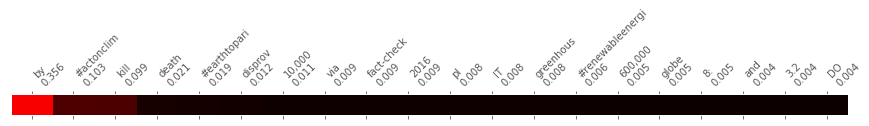

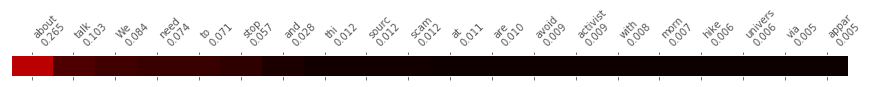

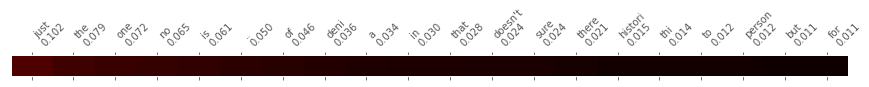

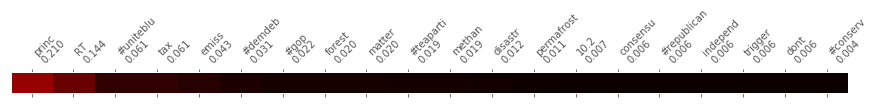

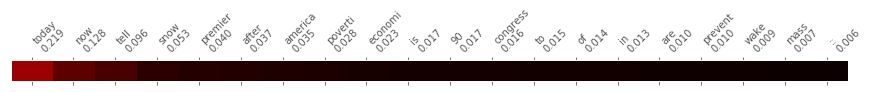

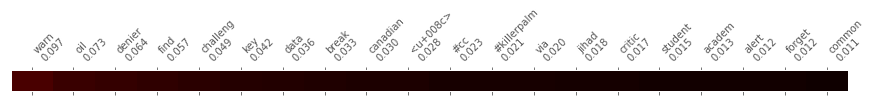

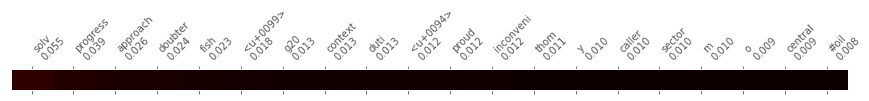

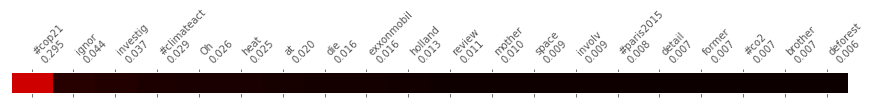

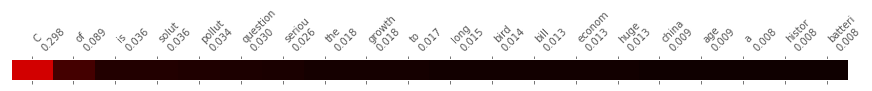

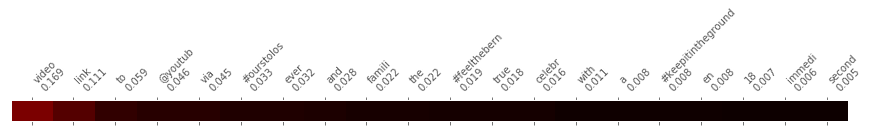

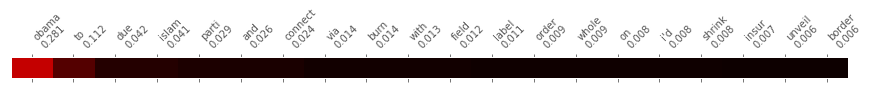

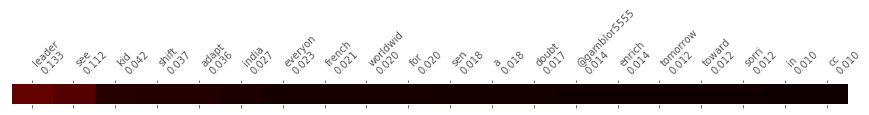

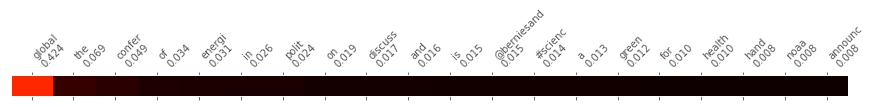

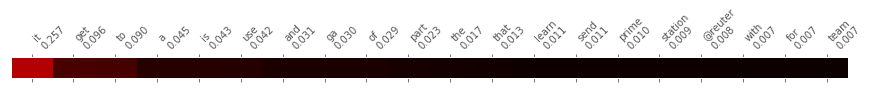

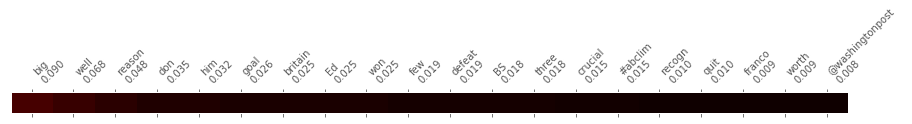

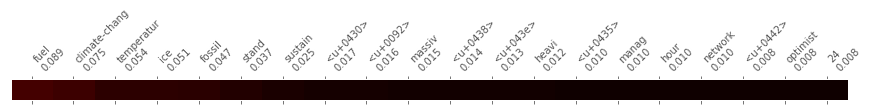

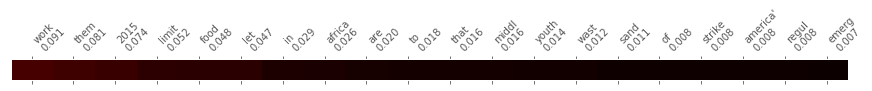

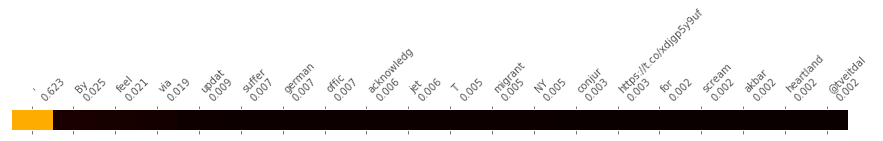

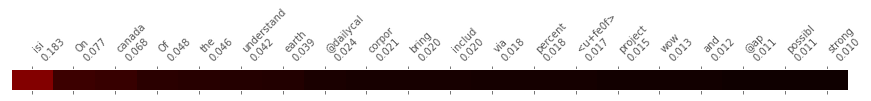

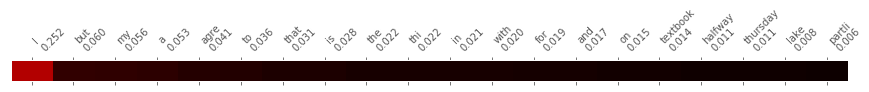

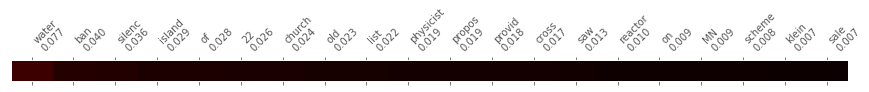

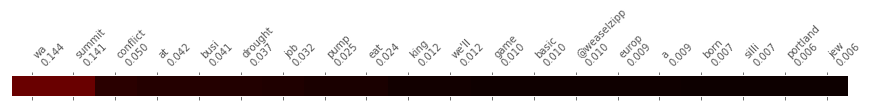

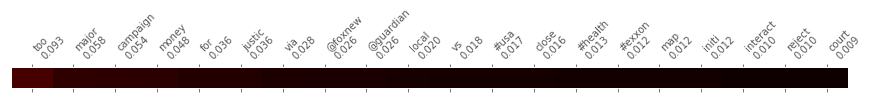

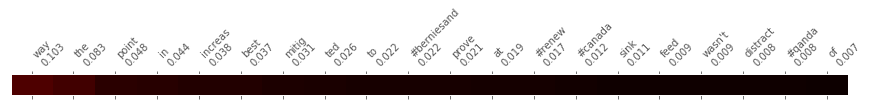

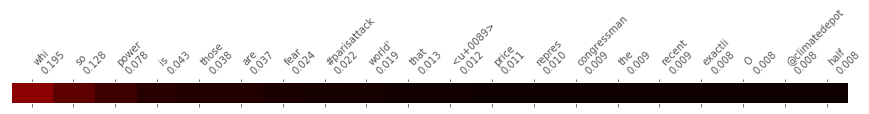

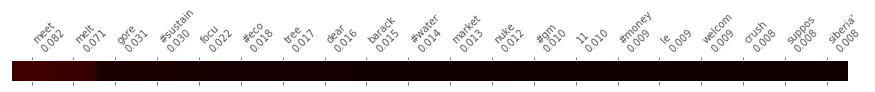

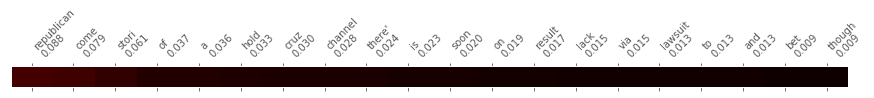

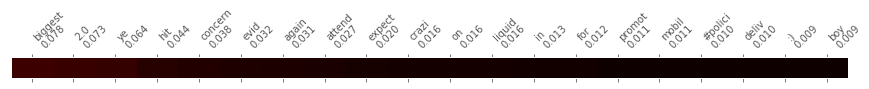

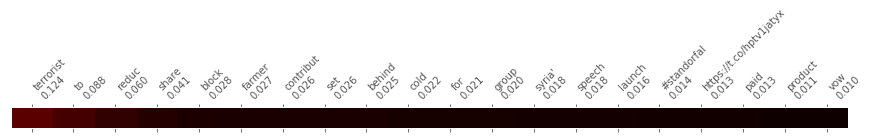

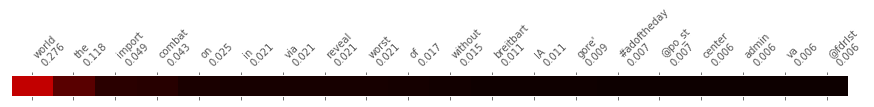

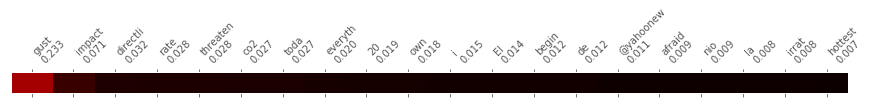

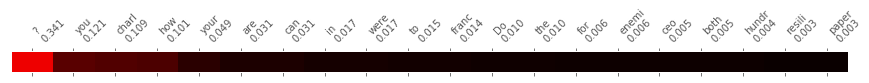

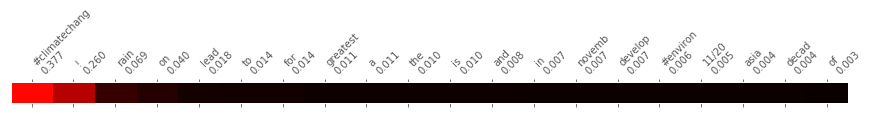

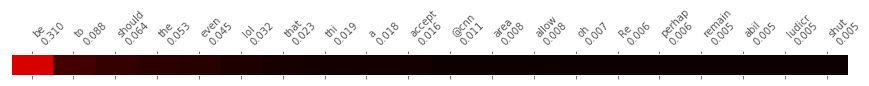

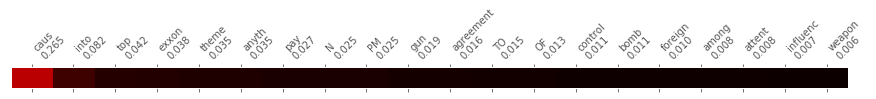

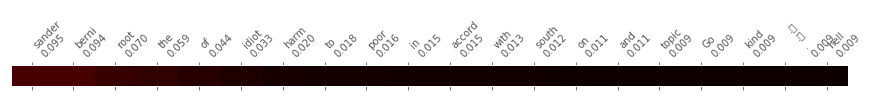

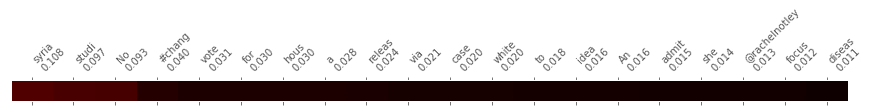

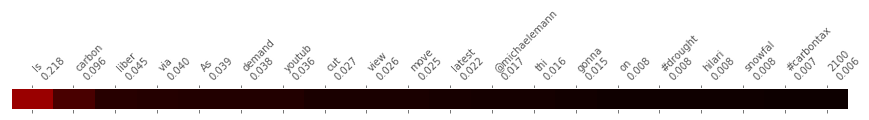

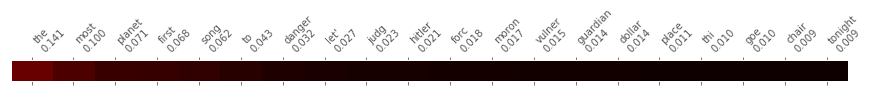

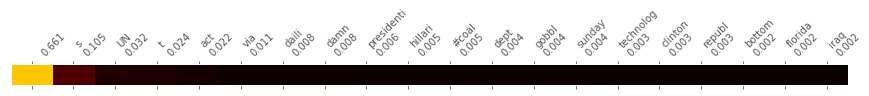

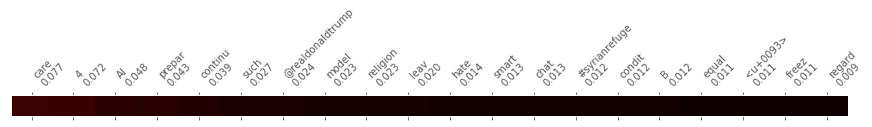

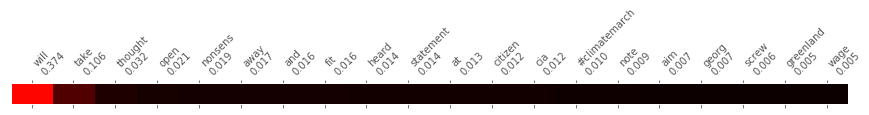

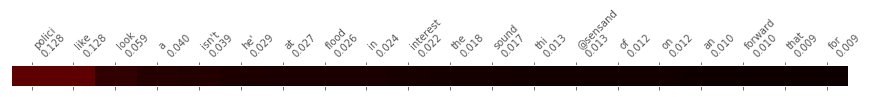

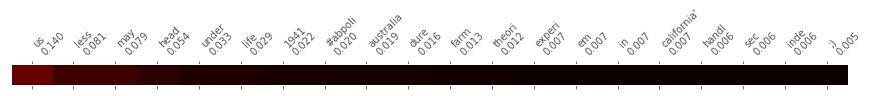

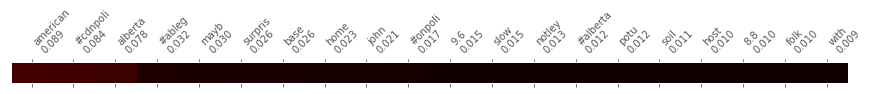

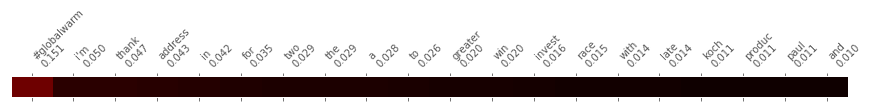

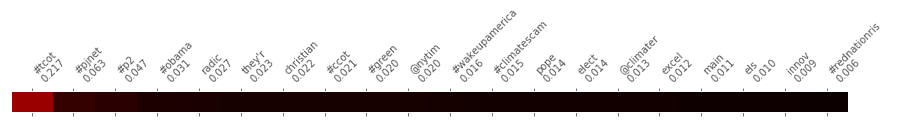

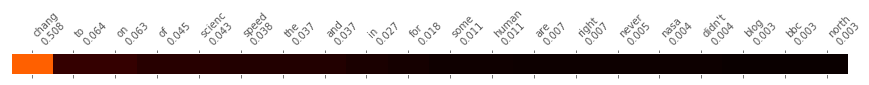

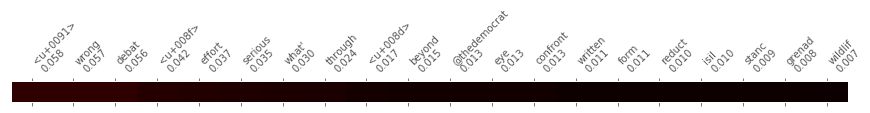

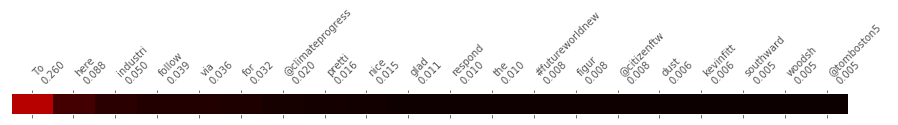

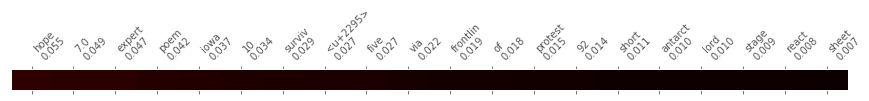

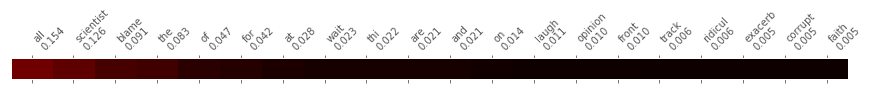

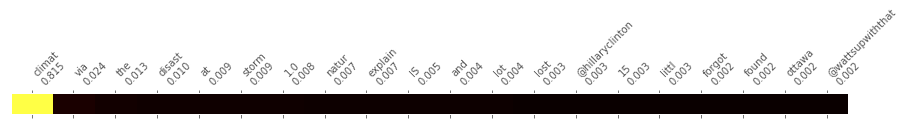

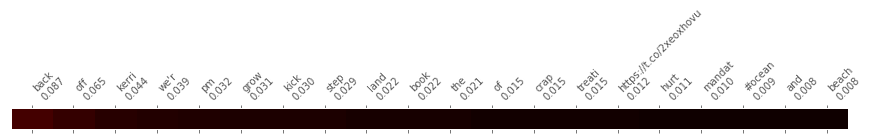

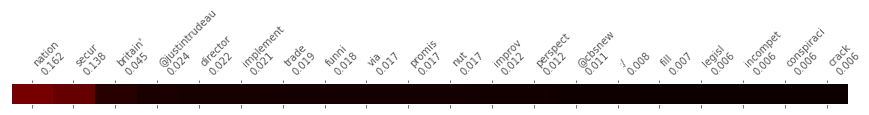

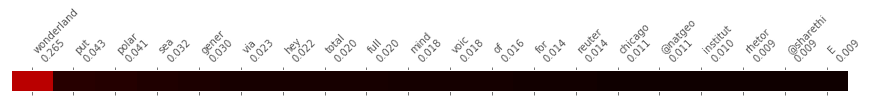

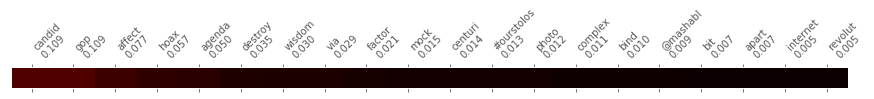

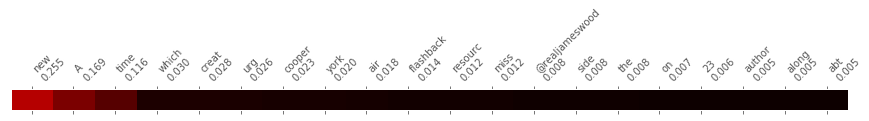

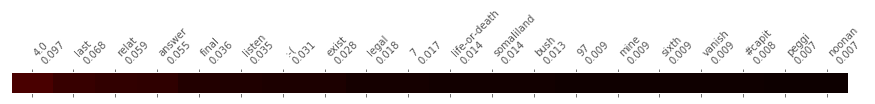

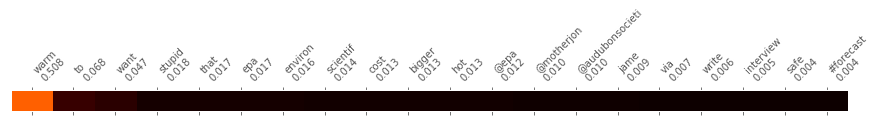

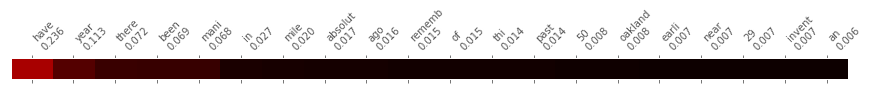

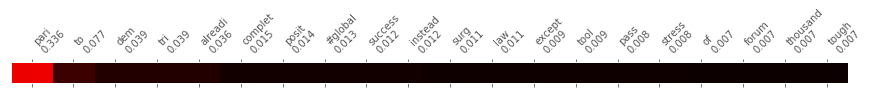

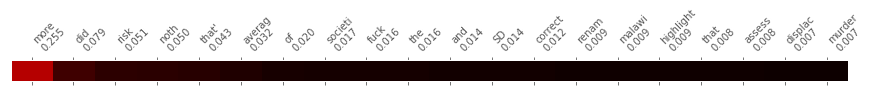

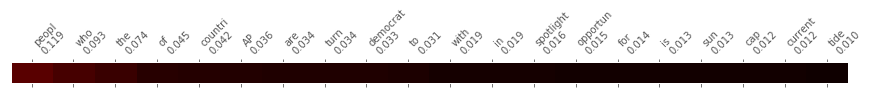

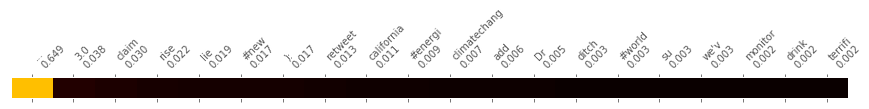

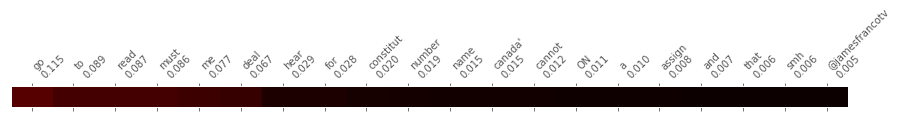

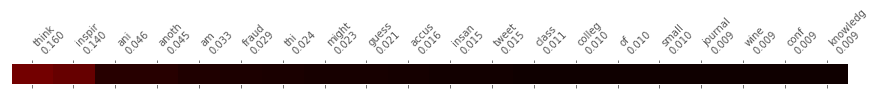

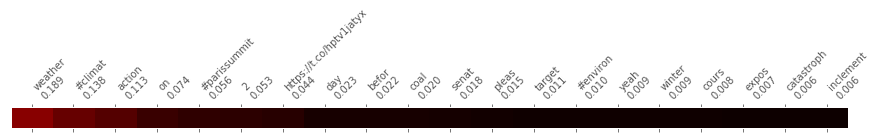

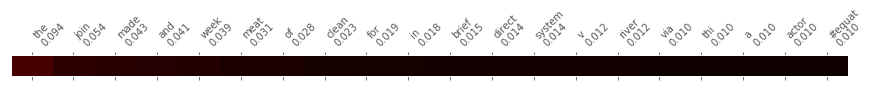

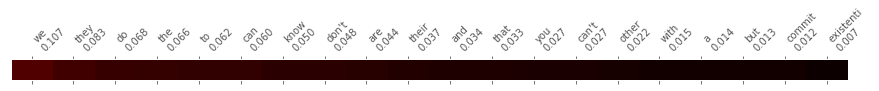

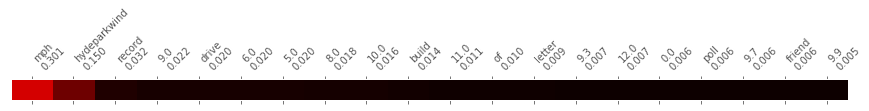

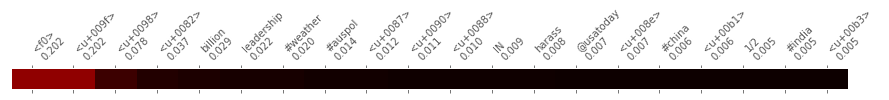

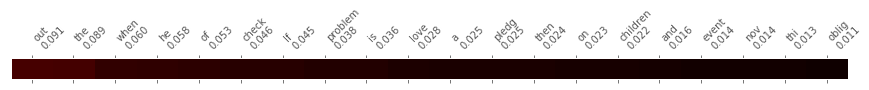

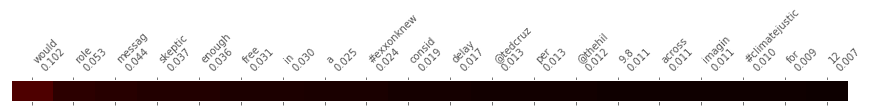

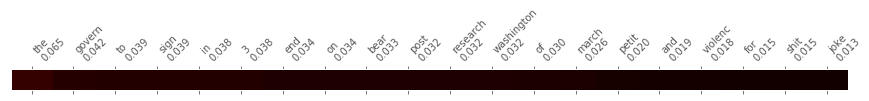

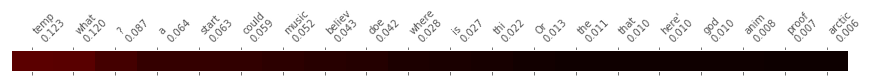

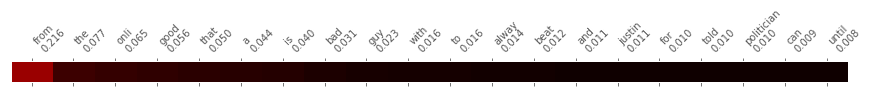

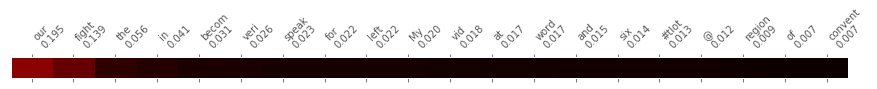

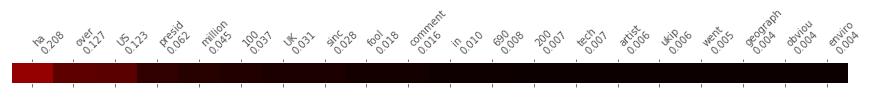

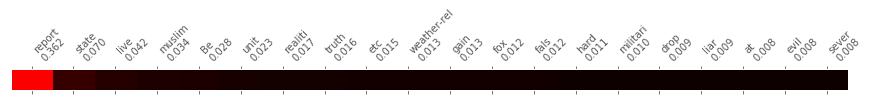

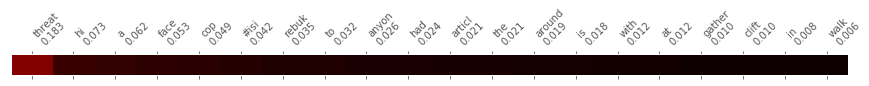

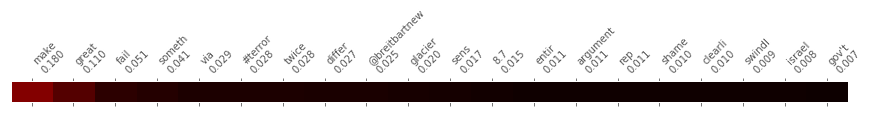

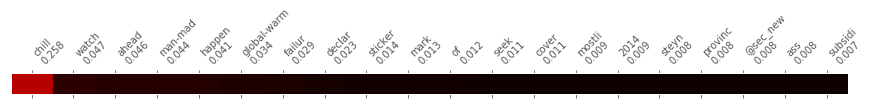

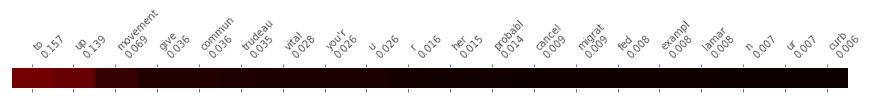

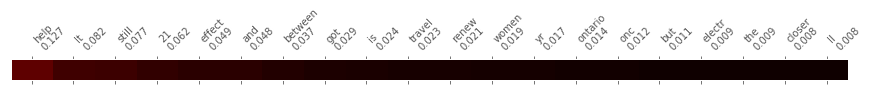

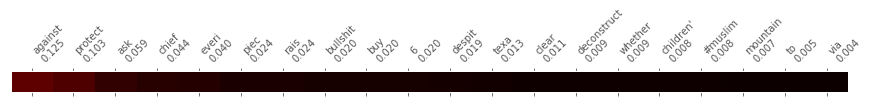

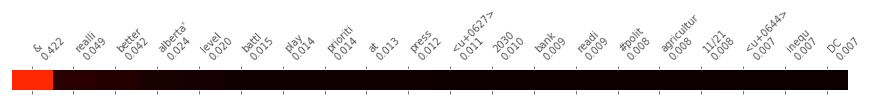

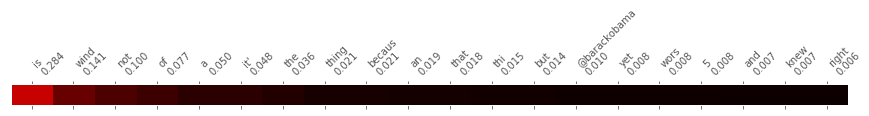

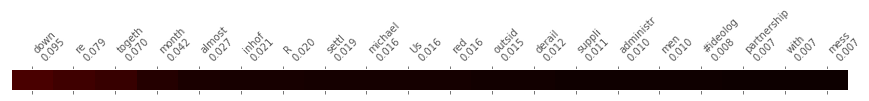

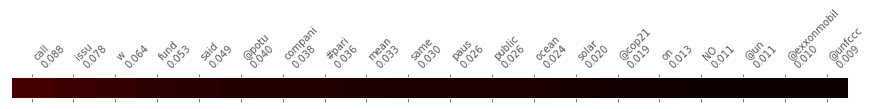

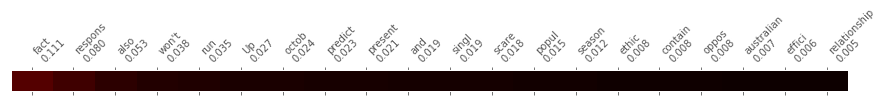

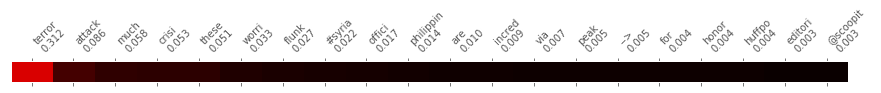

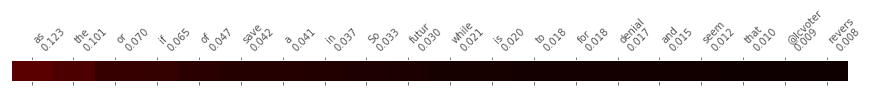

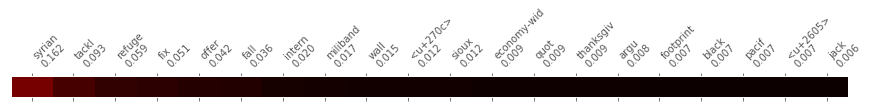

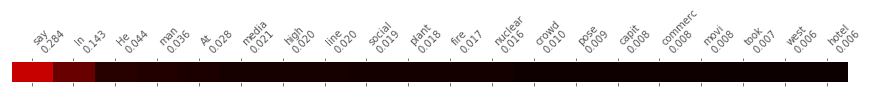

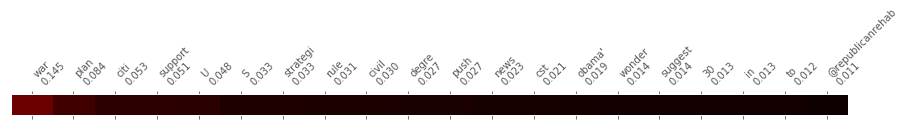

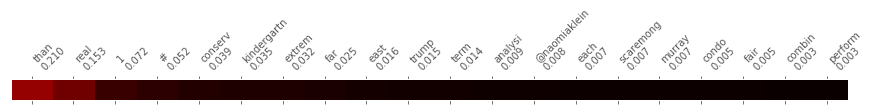

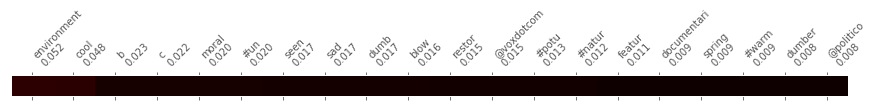

In [294]:
for i in range(K):
    if i == 0:
        fig = plt.figure(figsize=(15,6))
        ax = fig.add_subplot(111)
        ax.grid(False)
        
        mat = [x for x in reversed(np.arange(0.0,1.05,0.05))]
        ax.matshow(np.array(zip([0]*len(mat),mat)).T, vmin=0., vmax=1., cmap=plt.cm.hot)
        ax.set_xticklabels(['{0:.2f}'.format(x) for x in mat], rotation=45)
        for tick in ax.xaxis.get_majorticklabels():
            tick.set_horizontalalignment('left')
        ax.set_ylim(0.5,1)
        ax.set_yticks([])
        ax.set_yticklabels([])
        plt.xticks(np.arange(0, len(mat), 1.0))
        plt.title('Top 20 Words per Topic by Word Probabilities', y=3, fontsize=20)
        
    fig = plt.figure(figsize=(15,1))
    ax = fig.add_subplot(111)
    ax.grid(False)
    
    mat = pd.DataFrame(df_viz[i][df_viz[i] > 0]).sort_values(by=i, ascending=False)
    ax.matshow(np.array(zip([0]*len(mat.values),list(mat.values))).T, vmin=0., vmax=1., cmap=plt.cm.hot)
    ax.set_xticks(np.arange(0, len(mat.values), 1.0))
    ax.set_xticklabels([mat.index.values[x] + "\n"'{0:.3f}'.format(float(mat.values[x])) for x in range(len(mat.values))], rotation=45)
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('left')
    ax.set_ylim(0.5,1)
    ax.set_yticks([])
    ax.set_yticklabels([])
    
plt.show()

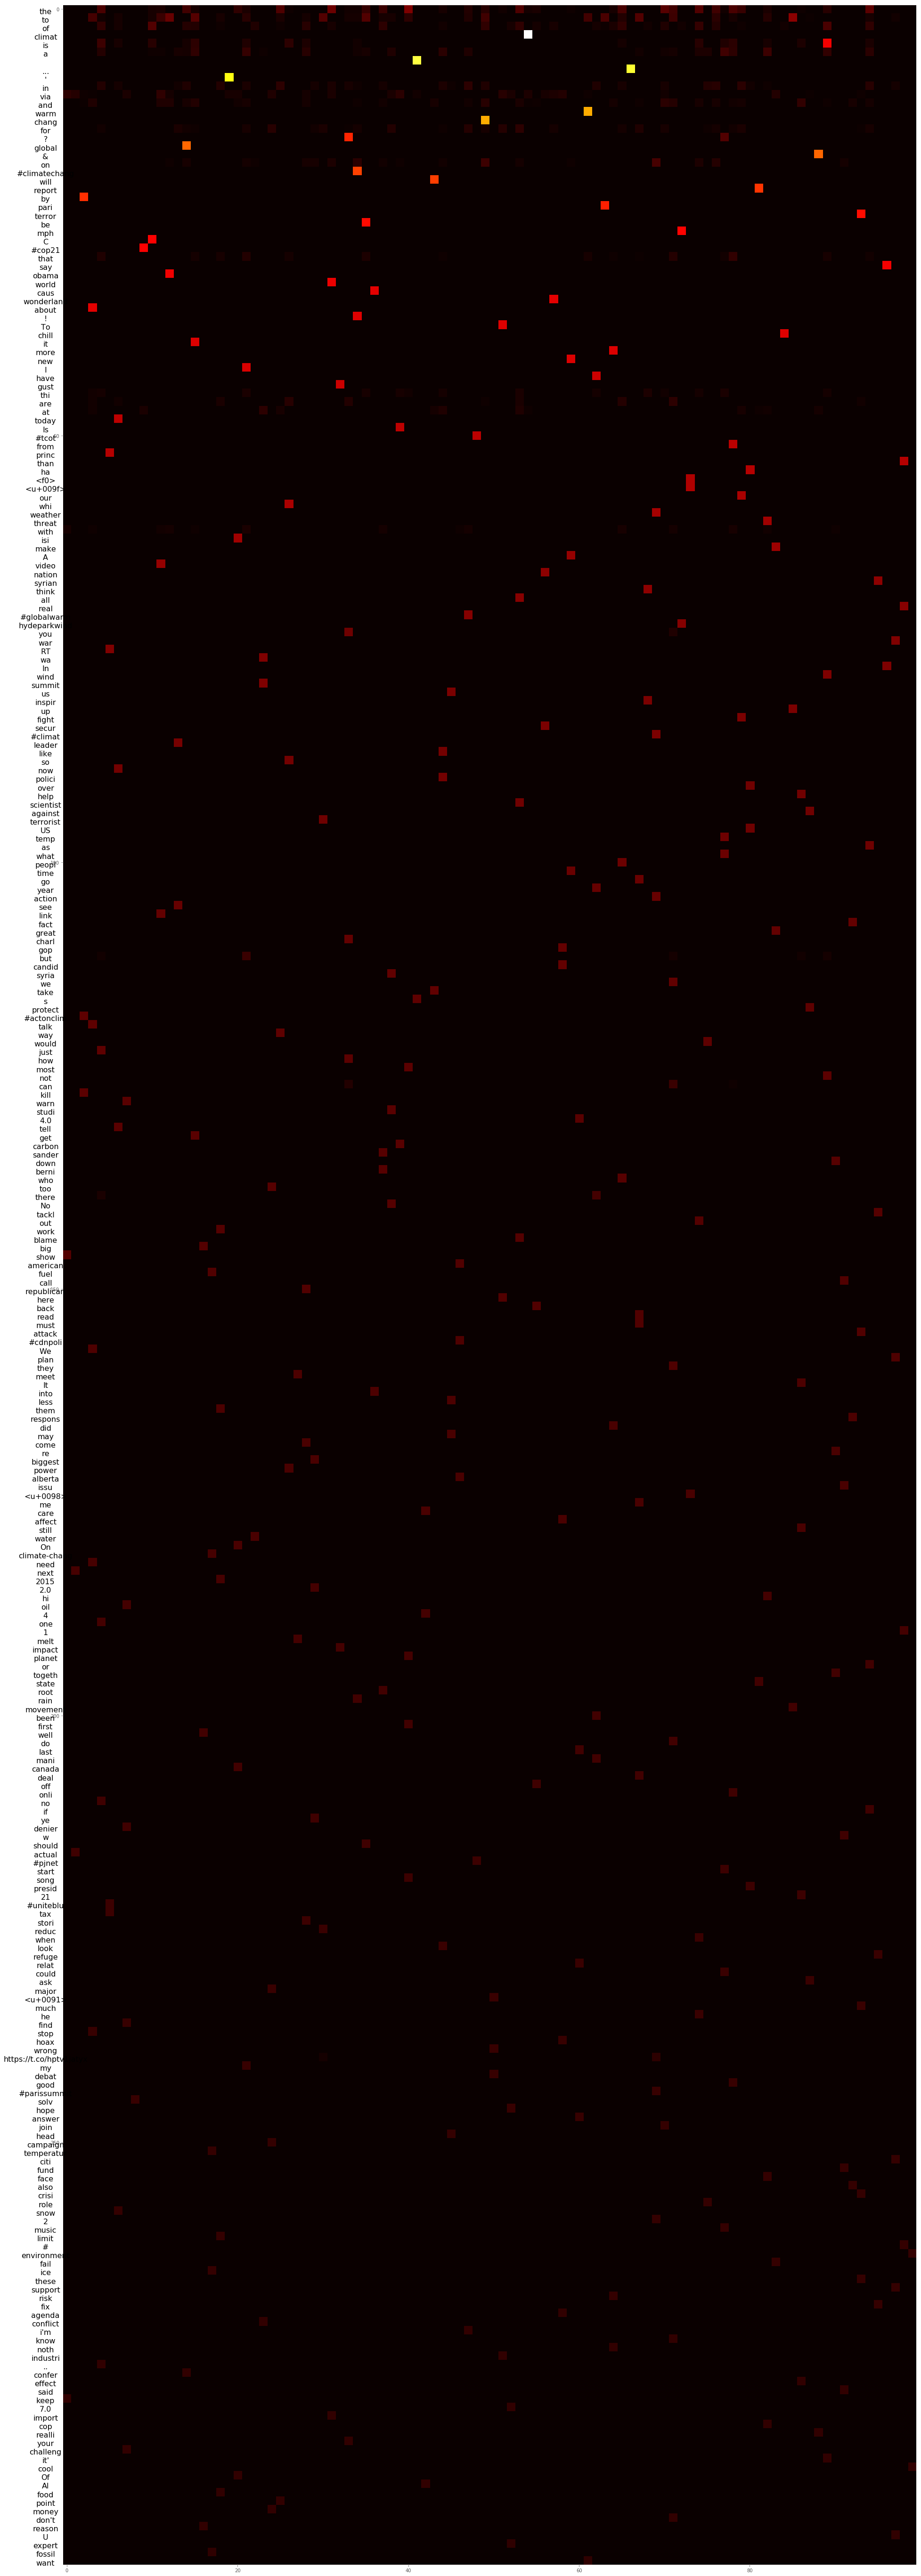

In [278]:
fig = plt.figure(figsize=(100, 100))
ax = fig.add_subplot(111)
ax.grid(False)

for val, key in enumerate(df_viz.index.values[:300]):
    ax.text(-2.5, val + 0.3, key, 
            horizontalalignment='center', verticalalignment='center'
            , fontsize=16)

ax.imshow(df_viz.iloc[:300,:100].values, cmap='hot', interpolation='nearest')
plt.show()